In [1]:
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import zscore
from collections import Counter
from matplotlib.patches import Rectangle, Patch
import subprocess


sys.path.insert(0, '../4_preffect')
from _config import configs
from preffect_factory import factory
import anndata as ad 
from _inference import( Inference )
from _misc import PAM50genes, PAM50genes_ensembl, BC_genes, BC360_Panel, BC360_Panel_ensemble

In [26]:
print(len(BC360_Panel))

776


In [ ]:
def list_subfolders(directory):
    subfolders = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
    return subfolders

# dataset of interests
# GSE167977
# GSE181466
# GSE209998
# GSE47462
# CountMeIn_BC_only
# DCIS (uncomment below) our_dcis_noblacklist

dataset_of_interest = "GSE167977"

# for third party datasets
folder_search = f'/path/to/' + dataset_of_interest + '_third_party_ffpe/bc360/'

# for our DCIS data 

# I need to fix this in the DCIS AnnData dataset directly to fix this 
#folder_search = f'/path/to/' + dataset_of_interest + '/bc360/'


all_subfolders = sorted(list_subfolders(folder_search))

all_subfolders = all_subfolders[3:4]

print("All sub-folders:", all_subfolders)

All sub-folders: ['Simple_E6000_M88_NB_XW2000_KLW.1']


In [3]:
configs['task'] = 'reinstate'

pr_reinstate = {}
pr_count = 0

for dir_name in all_subfolders:

    dir_name = re.sub(r'\s+', '', dir_name)
    full_path = folder_search + "/" + dir_name
    configs['output_path'] = full_path
    configs['cuda_device_num'] = 2
    pr_reinstate[pr_count] = factory(task='reinstate', configs=configs, trigger_setup=True)
    
    configs['always_save'] = False

    pr_data = pr_reinstate[0]

    configs_inf = pr_data.configs.copy()
    configs_inf['task'] = 'inference'
    inference_instance = Inference(pr_data, task='inference', inference_key = configs_inf['inference_key'], configs=configs_inf)
    inference_instance.run_inference()
    inference_instance.configs_inf['inference_key'] = 'endogenous'
    inference_instance.register_inference_run()


    pr_count += 1


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


765


In [ ]:
# Lets subtype using the inferred counts
adata = inference_instance.return_counts_as_anndata()

adata_write_path = configs_inf['output_path'] + "inference/endogenous/model_counts.h5ad"

# for a particular run for GSE167977
#adata_write_path = "/path/to/GSE167977_third_party_ffpe/bc360/Simple_E6000_M132_NB_XW2000_KLW.1/inference/endogenous/model_counts.h5ad"
adata[0].copy().write(adata_write_path)

# VST normalization -> Subtyping is done in an R script (porting it to Python was just a pain)
subprocess.run(["Rscript", "/path/to/4_vst_and_subtyping_anndata.R", adata_write_path])

adata_updated = ad.read_h5ad(adata_write_path)


In [5]:
print(adata_updated.var_names)

Index(['ACTB', 'COL6A3', 'VCAN', 'VIM', 'FBN1', 'SLC39A6', 'MUC1', 'GATA3',
       'POLR2A', 'UBB',
       ...
       'WNT6', 'LEFTY2', 'EFNA3', 'MIA', 'KLRK1', 'FZD9', 'TLX1', 'CXCL5',
       'CD68', 'CACNG6'],
      dtype='object', length=765)


50
Num neighbors:  10


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


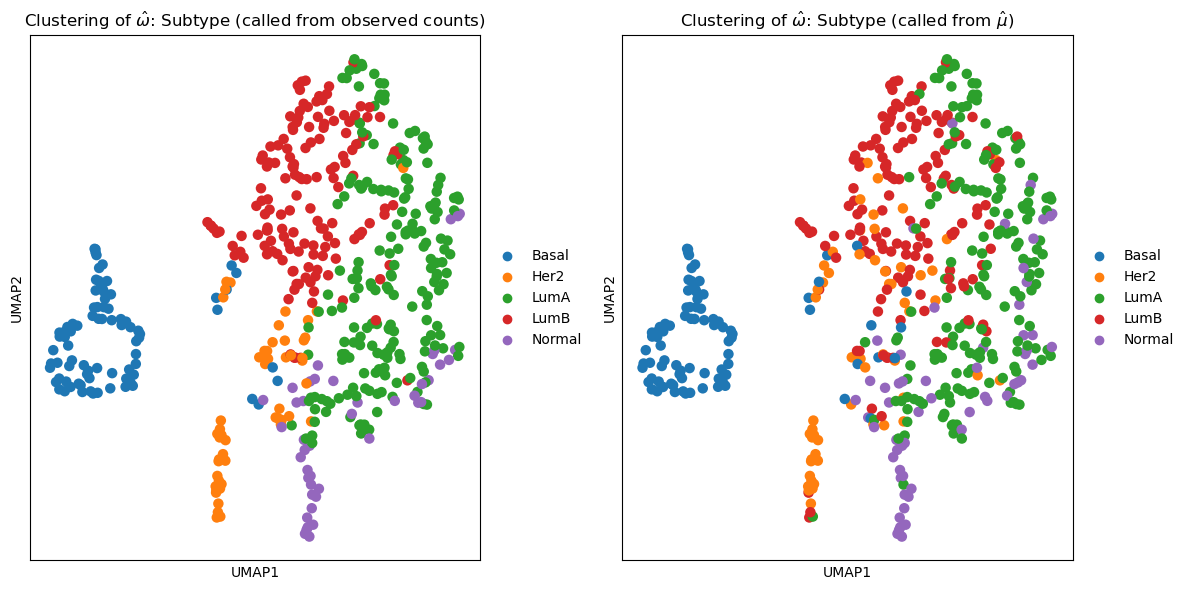

In [6]:
import scanpy as sc
# lets do clustering here, that way we can play around with settings
adata[0] = adata_updated.copy()


# if you want to cluster on omega, include this line. Comment out for counts.

adata[0].X = adata[0].layers["px_omega"] 

adata[0] = adata[0][:, adata[0].var_names.isin(PAM50genes)].copy()

# proving we found all 50 PAM50 genes
print(len(adata[0].var_names))

adata_tumour_tissue = adata[0].copy()

for i in range(1):
    print("Num neighbors: ", i + 10)
    sc.pp.neighbors(adata_tumour_tissue, n_neighbors=i + 5, use_rep='X')  # Adjust n_neighbors based on your dataset
    sc.tl.umap(adata_tumour_tissue)

    # side-by-side without leiden
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
    sc.pl.umap(adata_tumour_tissue, color='subtype_endogenous', ax=axes[0], show=False, title=r'Clustering of $\hat{\omega}$: Subtype (called from observed counts)')
    
    sc.pl.umap(adata_tumour_tissue, color='subtype_2', ax=axes[1], show=False, title=r'Clustering of $\hat{\omega}$: Subtype (called from $\hat{\mu}$)')


    plt.tight_layout()
    plt.show()

In [7]:
matches_by_index = sum(a == b for a, b in zip(adata_tumour_tissue.obs['subtype'], adata_tumour_tissue.obs['subtype_2']))
mismatches_by_index = len(adata_tumour_tissue.obs['subtype']) - matches_by_index
print(matches_by_index)
print(mismatches_by_index)

431
97


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


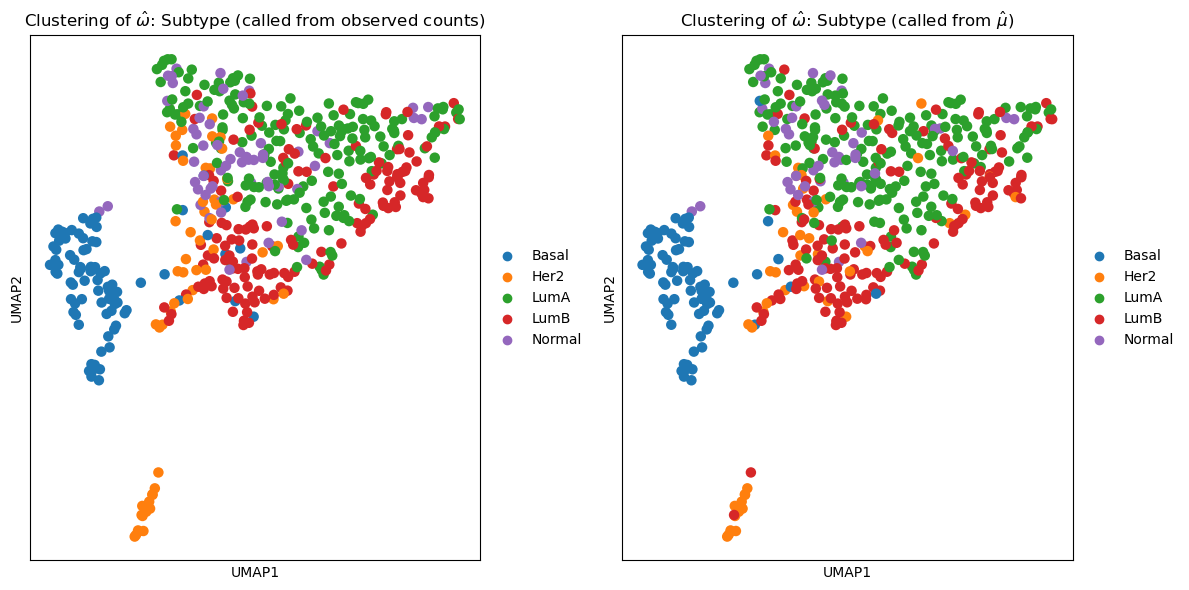

In [8]:
# lets do clustering here, that way we can play around with settings
adata[0] = adata_updated.copy()

# if you want to cluster on omega, include this line. Comment out for counts.

adata[0].X = adata[0].layers["original_counts"]

adata[0] = adata[0][:, adata[0].var_names.isin(PAM50genes)].copy()


row_sums = adata[0].X.sum(axis=1)  # sum over columns => shape (n,)
adata[0].X = adata[0].X / row_sums[:, np.newaxis]


# need to convert it to an omage (counts / library size)

adata_tumour_tissue = adata[0].copy()


sc.pp.neighbors(adata_tumour_tissue, n_neighbors=10, use_rep='X')  # Adjust n_neighbors based on your dataset
sc.tl.umap(adata_tumour_tissue)

# side-by-side without leiden
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
sc.pl.umap(adata_tumour_tissue, color='subtype_2', ax=axes[0], show=False, title=r'Clustering of $\hat{\omega}$: Subtype (called from observed counts)')

sc.pl.umap(adata_tumour_tissue, color='subtype_endogenous', ax=axes[1], show=False, title=r'Clustering of $\hat{\omega}$: Subtype (called from $\hat{\mu}$)')



plt.tight_layout()
plt.show()

/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


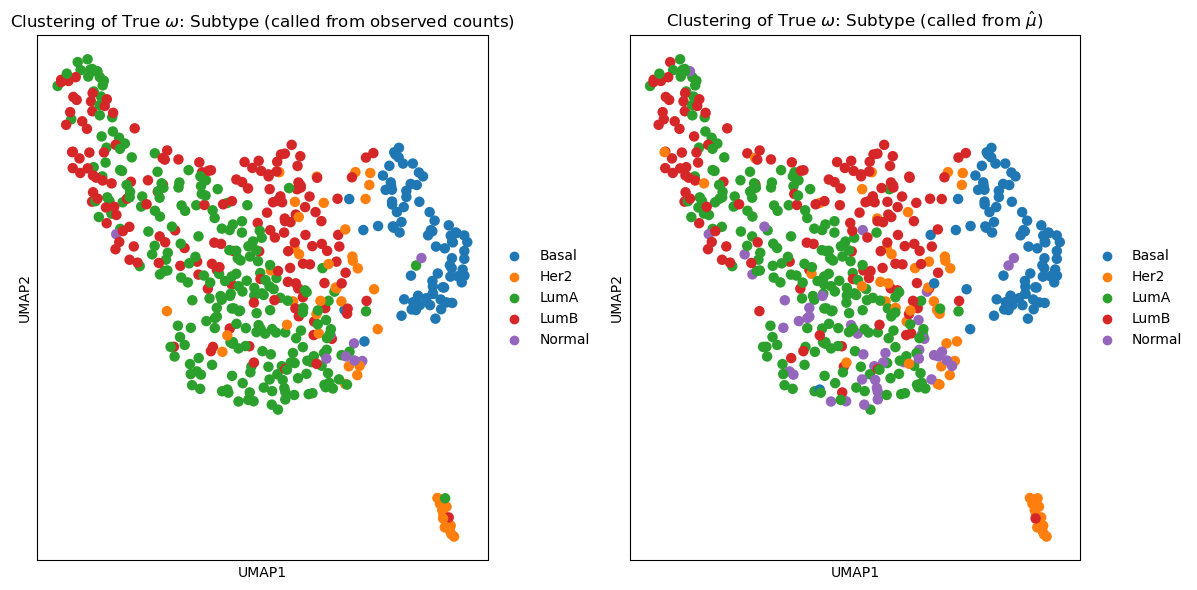

/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


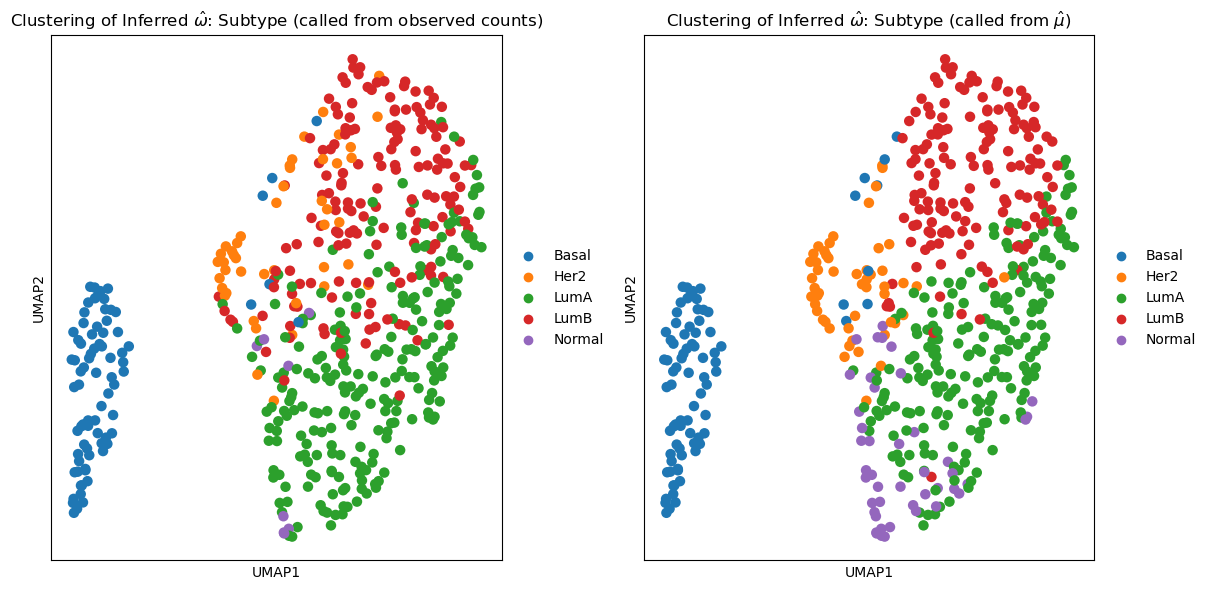

In [ ]:
adata[0] = adata_updated.copy()
adata[0].X = adata[0].layers["original_counts"]
adata[0] = adata[0][:, adata[0].var_names.isin(BC360_Panel)].copy()
row_sums = adata[0].X.sum(axis=1)  # sum over columns => shape (n,)

adata_original_counts = adata[0][:, adata[0].var_names.isin(PAM50genes)].copy()

adata[0].X = adata[0].X / row_sums[:, np.newaxis]
# and now that we have the omega, now we filter for PAM50 
adata[0] = adata[0][:, adata[0].var_names.isin(PAM50genes)].copy()
adata_original_omega = adata[0].copy()


# if you want to cluster on omega, include this line. Comment out for counts.
adata_inferred = inference_instance.return_counts_as_anndata() # just setting adata_inferred here, I don't use the data
adata_inferred[0] = adata_updated.copy()

adata_inferred_counts = adata_inferred[0][:, adata_inferred[0].var_names.isin(PAM50genes)].copy()


adata_inferred[0].X = adata_inferred[0].layers["px_omega"] 
adata_inferred[0] = adata_inferred[0][:, adata_inferred[0].var_names.isin(PAM50genes)].copy()
adata_inferred_omega = adata_inferred[0].copy()

sc.pp.neighbors(adata_original_omega, n_neighbors=15, use_rep='X')  # Adjust n_neighbors based on your dataset
sc.tl.umap(adata_original_omega)
sc.pp.neighbors(adata_inferred_omega, n_neighbors=15, use_rep='X')  # Adjust n_neighbors based on your dataset
sc.tl.umap(adata_inferred_omega)

# side-by-side without leiden
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
sc.pl.umap(adata_original_omega, color='subtype', ax=axes[0], show=False, title=r'Clustering of True $\omega$: Subtype (called from observed counts)')                
sc.pl.umap(adata_original_omega, color='subtype_endogenous', ax=axes[1], show=False, title=r'Clustering of True $\omega$: Subtype (called from $\hat{\mu}$)') 

write_path = "/path/to/3_real_data_subtype_explore/bc360/"
file_path = "umap_plots." + dataset_of_interest + ".pdf"

plt.savefig(write_path + file_path, format='pdf')

plt.tight_layout()
plt.show()

# side-by-side without leiden
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
sc.pl.umap(adata_inferred_omega, color='subtype', ax=axes[0], show=False, title=r'Clustering of Inferred $\hat{\omega}$: Subtype (called from observed counts)')         
sc.pl.umap(adata_inferred_omega, color='subtype_endogenous', ax=axes[1], show=False, title=r'Clustering of Inferred $\hat{\omega}$: Subtype (called from $\hat{\mu}$)')

plt.savefig(write_path + file_path, format='pdf')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def create_clustermap(
    adata,
    adata2=None,
    subtype_col="subtype_2",
    method="complete",
    metric="euclidean",
    cmap="Reds",
    figsize=(10, 8),
    x_label="Samples",
    y_label="Omega", y_label2="",
    label_fontsize=6,
    scale_by=None,        # 'row', 'column', or None
    rotate_plot=False,
    title="",
    title2=""
):
    """
    Creates a Seaborn clustermap from an AnnData object.  
    
    1) Optionally scales each row or column via z-score.  
    2) Optionally 'rotates' the plot by transposing the data (so rows become columns).  
    3) Includes annotation bars for 'subtype' and 'stroma_type' if they exist in adata.obs.  
    4) Sets smaller font sizes for axis labels and tick labels.

    Parameters
    ----------
    adata : AnnData
        Contains .X (expression matrix) and .obs (sample annotations).
    subtype_col : str
        The column in adata.obs used for "subtype" annotation.
    stroma_col : str
        The column in adata.obs used for "stroma_type" annotation.
    method : str
        Linkage method (e.g. 'complete', 'average', 'ward').
    metric : str
        Distance metric (e.g. 'euclidean', 'correlation').
    cmap : str
        Colormap for the heatmap (default='Reds').
    figsize : tuple
        Size of the clustermap (width, height).
    x_label : str
        Label for x-axis in the final plot (default='Genes').
    y_label : str
        Label for y-axis in the final plot (default='Samples').
    label_fontsize : int
        Font size for axis labels and tick labels.
    scale_by : str or None
        If 'column', each column is z-scored.  
        If 'row', each row is z-scored.  
        If None, no scaling is performed.
    rotate_plot : bool
        If True, transpose the data so original rows become columns (effectively rotating the plot 90°).

    Returns
    -------
    None
        Displays the resulting clustermap.
    """
    # Renaming "subtype" and "stroma_type"
    subtype_rename_map = {
        "Basal": "basal",
        "Her2": "her2-enriched",
        "LumA": "luminal A",
        "LumB": "luminal B",
        "Normal": "normal-like",
        "Claudin": "claudin"
    }   

    adata.obs.rename(columns={"subtype_endogenous": "subtype mu"}, inplace=True)
    adata.obs.rename(columns={"subtype_2": "subtype counts"}, inplace=True)
    subtype_col = "subtype counts"

    if "subtype counts" in adata.obs:
        adata.obs["subtype counts"] = adata.obs["subtype counts"].replace(subtype_rename_map)
        adata.obs["subtype mu"] = adata.obs["subtype mu"].replace(subtype_rename_map)

    df = pd.DataFrame(
        np.log2(adata.X + 1),
        index=adata.obs_names,   # typically samples/cells
        columns=adata.var_names  # typically genes
    )

    if (adata2 is not None):
        adata2.obs.rename(columns={"subtype_endogenous": "subtype mu"}, inplace=True)
        adata2.obs.rename(columns={"subtype_2": "subtype counts"}, inplace=True)

        if "subtype counts" in adata2.obs:
            adata2.obs["subtype counts"] = adata2.obs["subtype counts"].replace(subtype_rename_map)
            adata2.obs["subtype mu"] = adata2.obs["subtype mu"].replace(subtype_rename_map)

        df2 = pd.DataFrame(
            np.log2(adata2.X), # omega is always >0
            index=adata2.obs_names,   # typically samples/cells
            columns=adata2.var_names  # typically genes
        )

    # 2) Optional Scaling
    # If scale_by='column', we do standard (z-score) scaling per GENE.
    # If scale_by='row', we do standard (z-score) scaling per SAMPLE.
    if scale_by == 'column':
        df = (df - df.mean(axis=0)) / df.std(axis=0)
    elif scale_by == 'row':
        # For each row, subtract its own mean and divide by its own std
        df = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)
    elif scale_by == 'column_median':
        df = (df - df.median(axis=0)) # / df.std(axis=0)
        if (adata2 is not None):
            df2 = (df2 - df2.median(axis=0)) # / df2.std(axis=0)
    elif scale_by == 'row_median':
        df = df.sub(df.median(axis=1), axis=0) # .div(df.std(axis=1), axis=0)
        if (adata2 is not None):
            df2 = df2.sub(df2.median(axis=1), axis=0) # .div(df2.std(axis=1), axis=0)

    # 3) Prepare Annotation Bars
    # The sample-level annotations go on the rows by default,
    # or on the columns if we rotate the data.
    row_colors_df = None
    col_colors_df = None
    legend_handles = []

    # Subtype annotation similar to UMAP colors
    subtype_palette = {
        "basal": "red",     
        "her2-enriched": "orange",
        "luminal A": "darkblue", 
        "luminal B": "lightblue",
        "normal-like": "green",
        "claudin": "grey"
    }

    subtypes = adata.obs[subtype_col].astype(str)
    unique_subtypes = subtypes.unique()
    subtype_colors = subtypes.map(subtype_palette)

    subtypes_endo = adata.obs["subtype mu"].astype(str)
    unique_subtypes = subtypes_endo.unique()
    subtype_endo_colors = subtypes_endo.map(subtype_palette)

    legend_handles = []
    for val in unique_subtypes:
    # val is your subtype label, e.g. "basal"
        legend_handles.append(
            mpatches.Patch(color=subtype_palette[val], label=f"{subtype_col}: {val}")
        )

    # Combine these annotation color columns into a single DataFrame
    if (subtype_colors is not None):
        annotation_df = pd.DataFrame(index=df.index)
        if subtype_colors is not None:
            annotation_df[subtype_col] = subtype_colors
            annotation_df["subtype mu"] = subtype_endo_colors


        # Decide whether annotation bars belong to rows or columns based on rotate_plot
        if rotate_plot:
            # If we are transposing df, samples move to columns, so annotation is col_colors
            col_colors_df = annotation_df
        else:
            row_colors_df = annotation_df


    # 4) Optionally transpose data to 'rotate' the heatmap
    data_for_plot = df.T if rotate_plot else df
    if (adata2 is not None):
        data_for_plot2 = df2.T if rotate_plot else df2

    #print(np.min(data_for_plot, axis=0))
    #print(data_for_plot.median(axis=0))
    #print(data_for_plot.std(axis=0))
    #print(data_for_plot.max(axis=0))

    mini = np.min(np.min(data_for_plot))
    maxi = np.max(np.max(data_for_plot))

    # Find if abs(mini) or maxi is greater, and set the other one to that value so 0 point is the middle
    largest_abs = max(abs(mini), abs(maxi))
    mini = -largest_abs
    maxi =  largest_abs

    # 5) Create the Clustermap
    g = sns.clustermap(
        data_for_plot,
        row_colors=row_colors_df,
        col_colors=col_colors_df,
        method=method,
        metric=metric,
        cmap=cmap,
        figsize=figsize,
        dendrogram_ratio=(0.2, 0.2),
        row_cluster=True,
        vmin=mini, vmax=maxi
    )


    # 6) Adjust Axis Labels and Tick Fonts
    labels_x = g.data2d.columns 
    labels_y = g.data2d.index

    g.ax_heatmap.set_yticks(np.arange(len(labels_y)) + 0.5) 
    g.ax_heatmap.set_yticklabels(labels_y)

    g.ax_heatmap.tick_params(axis='y', labelsize=label_fontsize)
    g.ax_heatmap.set_xlabel('')

    # Remove all x-axis tick locations
    g.ax_heatmap.set_xticks([])

    # Remove all x-axis tick labels
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.set_xlabel(x_label)
    g.ax_heatmap.set_ylabel(y_label)

    g.fig.suptitle(title, fontsize=14, x=0.5, y=1.02) 

    #cbar = g.ax_heatmap.collections[0].colorbar

    # Manually set the desired tick locations and labels
    #cbar.set_ticks([-2, 0, 2, 4, 6, 8, 10])
    #cbar.set_ticklabels(["-2", "0", "2", "4", "6", "8", "10"])


    # 7) Build the Legend (if we have annotation bars)
    if legend_handles:
        g.ax_heatmap.legend(
            handles=legend_handles,
            loc="lower left",
            bbox_to_anchor=(-0.25, 0),
            title="Legend",
            prop={"size": 5}
        )

    write_path = "/path/to/3_real_data_subtype_explore/bc360/"
    g.fig.savefig(write_path + dataset_of_interest + title + ".pdf", format="pdf")

    # plotting a second data set in the same order as the first
    if (adata2 is not None):
        row_order = g.dendrogram_row.reordered_ind # we don't cluster on rows
        col_order = g.dendrogram_col.reordered_ind

        df2_reordered = data_for_plot2.iloc[row_order, col_order]

        mini = np.min(np.min(data_for_plot2))
        maxi = np.max(np.max(data_for_plot2))

        #print(np.min(data_for_plot2, axis=0))
        #print(data_for_plot2.median(axis=0))
        #print(data_for_plot2.std(axis=0))
        #print(data_for_plot2.max(axis=0))

        # Find if abs(mini) or maxi is greater, and set the other one to that value so 0 point is the middle
        largest_abs = max(abs(mini), abs(maxi))
        mini = -largest_abs
        maxi =  largest_abs

        g2 = sns.clustermap(
            df2_reordered,
            row_colors=row_colors_df,
            col_colors=col_colors_df,
            method=method,
            metric=metric,
            cmap=cmap,
            figsize=figsize,
            dendrogram_ratio=(0.2, 0.2),
            row_cluster=False,
            col_cluster=False,
            vmin=mini/1.2, vmax=maxi/1.2
        )

        labels_x = g2.data2d.columns 
        labels_y = g2.data2d.index

        g2.ax_heatmap.set_yticks(np.arange(len(labels_y)) + 0.5) 
        g2.ax_heatmap.set_yticklabels(labels_y)

        g2.ax_heatmap.tick_params(axis='y', labelsize=label_fontsize)
        g2.ax_heatmap.set_xlabel('')

        # Remove all x-axis tick locations
        g2.ax_heatmap.set_xticks([])

        # Remove all x-axis tick labels
        g2.ax_heatmap.set_xticklabels([])
        g2.ax_heatmap.set_xlabel(x_label)
        g2.ax_heatmap.set_ylabel(y_label2)

        g2.fig.suptitle(title2, fontsize=14, x=0.5, y=1.02) 

        #cbar = g2.ax_heatmap.collections[0].colorbar

        # Manually set the desired tick locations and labels
        #cbar.set_ticks([-2, 0, 2, 4, 6, 8, 10])
        #cbar.set_ticklabels(["-2", "0", "2", "4", "6", "8", "10"])
    
        g2.fig.savefig(write_path + dataset_of_interest + title + "_inferred.pdf", format="pdf")

        # the same plot again, but column clustered
        g3 = sns.clustermap(
            df2_reordered,
            row_colors=row_colors_df,
            col_colors=col_colors_df,
            method=method,
            metric=metric,
            cmap=cmap,
            figsize=figsize,
            dendrogram_ratio=(0.2, 0.2),
            row_cluster=True,
            col_cluster=True,
            vmin=mini/1.2, vmax=maxi/1.2
        )

        labels_x = g3.data2d.columns 
        labels_y = g3.data2d.index

        g3.ax_heatmap.set_yticks(np.arange(len(labels_y)) + 0.5) 
        g3.ax_heatmap.set_yticklabels(labels_y)

        g3.ax_heatmap.tick_params(axis='y', labelsize=label_fontsize)
        g3.ax_heatmap.set_xlabel('')

        # Remove all x-axis tick locations
        g3.ax_heatmap.set_xticks([])

        # Remove all x-axis tick labels
        g3.ax_heatmap.set_xticklabels([])
        g3.ax_heatmap.set_xlabel(x_label)
        g3.ax_heatmap.set_ylabel(y_label2)

        g3.fig.suptitle(title2, fontsize=14, x=0.5, y=1.02) 
        g3.fig.savefig(write_path + dataset_of_interest + title + "_inferred_clustered.pdf", format="pdf")
        #cbar = g3.ax_heatmap.collections[0].colorbar

        # Manually set the desired tick locations and labels
        #cbar.set_ticks([-2, 0, 2, 4, 6, 8, 10])
        #cbar.set_ticklabels(["-2", "0", "2", "4", "6", "8", "10"])

In [11]:
#print(adata_inferred_omega.obs)



In [ ]:
# double cluster test
print("Tumour True Counts vs Inferred Counts")
create_clustermap(adata=adata_original_counts, 
                  adata2=adata_inferred_counts,
                  scale_by="column_median", rotate_plot=True, 
                  figsize=(6, 7), y_label=r"$\mu$",  y_label2=r"$\hat{\mu}$",
                  metric="correlation",
                  title=r"Observed Counts",
                  title2=r"Fitted Counts")

In [13]:
import matplotlib.colors as mcolors
red_white_green = mcolors.LinearSegmentedColormap.from_list(
    "red_white_green", ["green", "white", "red"]
)

Observed Counts vs Fitted Omegas


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:85: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:85: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/numpy/core/fr

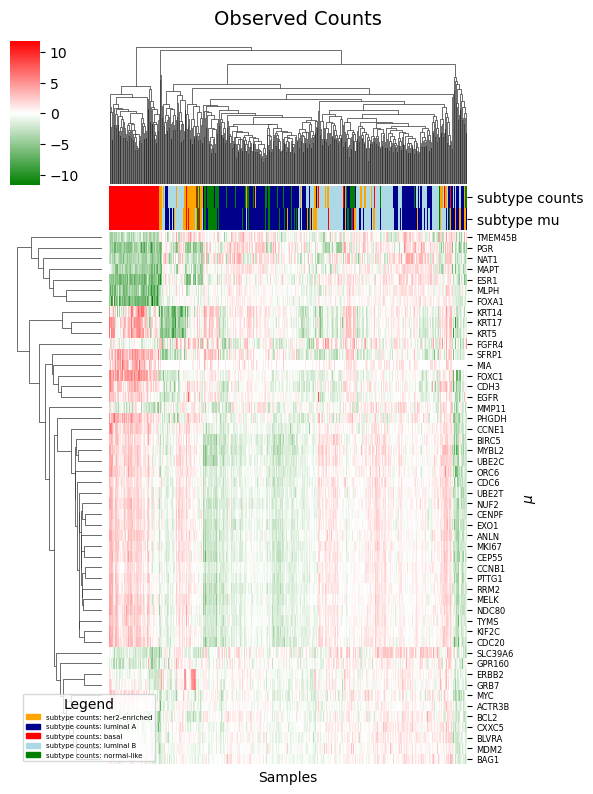

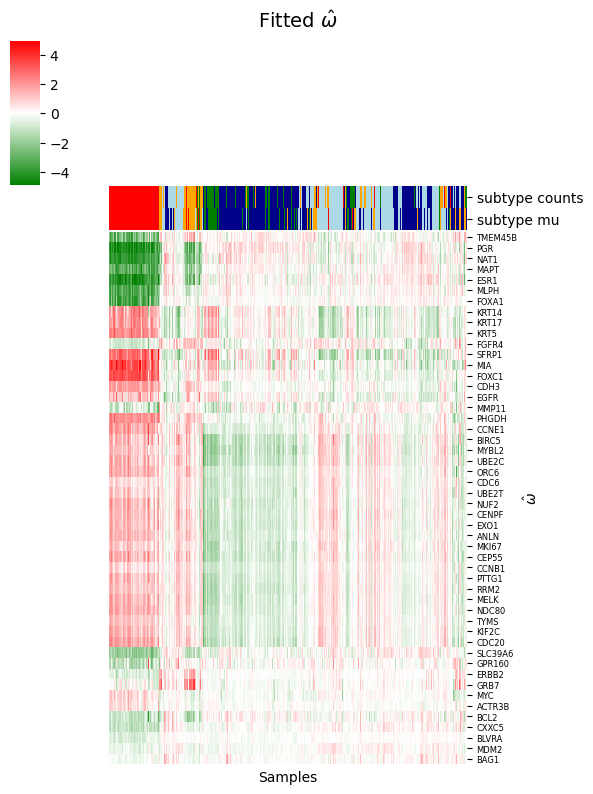

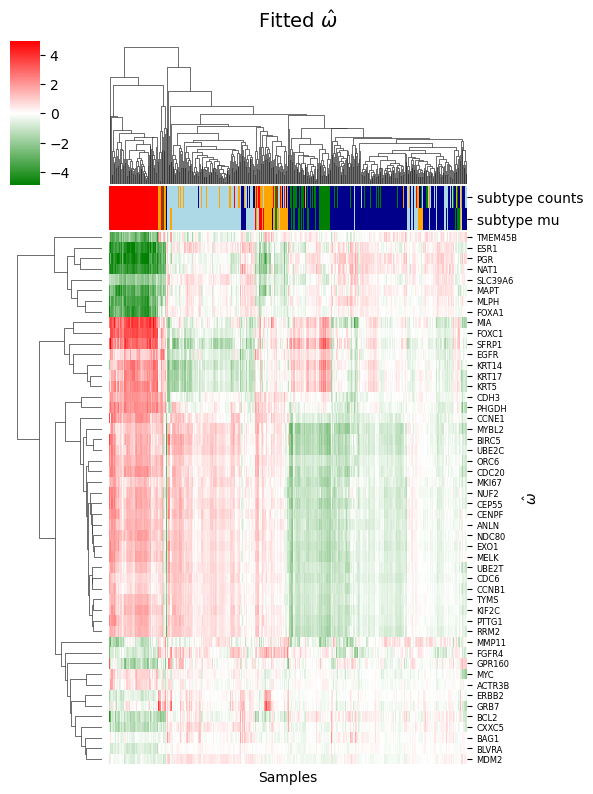

In [25]:
# double cluster test
print("Observed Counts vs Fitted Omegas")
create_clustermap(adata=adata_original_counts, 
                  adata2=adata_inferred_omega,
                  scale_by="column_median", rotate_plot=True, 
                  figsize=(6, 8), y_label=r"$\mu$", y_label2=r"$\hat{\omega}$",
                  method="average",
                  metric="euclidean",
                  title=r"Observed Counts",
                  title2=r"Fitted $\hat{\omega}$",
                  cmap=red_white_green)


# #"$\hat{\omega}$",